In [134]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchmetrics.functional import structural_similarity_index_measure
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity as ssim_func
from PIL import Image
from glob import glob
import os
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [53]:
# Define the root directory of the dataset as the current directory
data_root = '.'

# Get paths for each object folder under the main dataset
object_folders = ['bottle', 'cable', 'capsule', 'carpet','grid','hazelnut', 'leather','metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']

# Initialize lists for each data type
train_degraded = []
train_ground_truth = []
train_mask = []
val_degraded = []
val_ground_truth = []
val_mask = []

# Populate the paths for training and validation data
for obj in object_folders:
    # Paths to the Train folders for each object
    train_degraded.extend(glob(os.path.join(data_root, obj, 'Train', 'Degraded_image', '*', '*.png')))
    train_ground_truth.extend(glob(os.path.join(data_root, obj, 'Train', 'GT_clean_image', '*', '*.png')))
    train_mask.extend(glob(os.path.join(data_root, obj, 'Train', 'Defect_mask', '*', '*.png')))
    
    # Paths to the Validation folders for each object
    val_degraded.extend(glob(os.path.join(data_root, obj, 'Val', 'Degraded_image', '*', '*.png')))
    val_ground_truth.extend(glob(os.path.join(data_root, obj, 'Val', 'GT_clean_image', '*', '*.png')))
    val_mask.extend(glob(os.path.join(data_root, obj, 'Val', 'Defect_mask', '*', '*.png')))

# Check sample paths to ensure correctness
print("Sample Train Degraded Image Path:", train_degraded[0])
print("Sample Train Ground Truth Image Path:", train_ground_truth[0])
print("Sample Train Defect Mask Path:", train_mask[0])


if len(train_degraded) > len(train_ground_truth):
    train_degraded = train_degraded[:len(train_ground_truth)]


Sample Train Degraded Image Path: ./bottle/Train/Degraded_image/broken_small/002.png
Sample Train Ground Truth Image Path: ./bottle/Train/GT_clean_image/broken_small/002.png
Sample Train Defect Mask Path: ./bottle/Train/Defect_mask/broken_small/000_mask.png


In [159]:
train_degraded_by_obj = {}
train_ground_truth_by_obj = {}
train_mask_by_obj = {}
val_degraded_by_obj = {}
val_ground_truth_by_obj = {}
val_mask_by_obj = {}

for obj in object_folders:
    # Initialize lists for the current object in each dictionary
    train_degraded_by_obj[obj] = glob(os.path.join(data_root, obj, 'Train', 'Degraded_image', '*', '*.png'))
    train_ground_truth_by_obj[obj] = glob(os.path.join(data_root, obj, 'Train', 'GT_clean_image', '*', '*.png'))
    train_mask_by_obj[obj] = glob(os.path.join(data_root, obj, 'Train', 'Defect_mask', '*', '*.png'))
    
    val_degraded_by_obj[obj] = glob(os.path.join(data_root, obj, 'Val', 'Degraded_image', '*', '*.png'))
    val_ground_truth_by_obj[obj] = glob(os.path.join(data_root, obj, 'Val', 'GT_clean_image', '*', '*.png'))
    val_mask_by_obj[obj] = glob(os.path.join(data_root, obj, 'Val', 'Defect_mask', '*', '*.png'))


# Ensure equal length of degraded and ground truth lists for each object
for obj in object_folders:
    if len(train_degraded_by_obj[obj]) > len(train_ground_truth_by_obj[obj]):
        train_degraded_by_obj[obj] = train_degraded_by_obj[obj][:len(train_ground_truth_by_obj[obj])]
    if len(val_degraded_by_obj[obj]) > len(val_ground_truth_by_obj[obj]):
        val_degraded_by_obj[obj] = val_degraded_by_obj[obj][:len(val_ground_truth_by_obj[obj])]

In [54]:
# Custom Dataset Loader
class AnomalyDataset(Dataset):
    def __init__(self, degraded_img_paths, ground_truth_paths, mask_paths, transform=None):
        self.degraded_img_paths = degraded_img_paths
        self.ground_truth_paths = ground_truth_paths
        self.mask_paths = mask_paths
        self.transform = transform
    
    def __len__(self):
        return len(self.degraded_img_paths)
    
    def __getitem__(self, idx):
        degraded_img = Image.open(self.degraded_img_paths[idx]).convert("RGB")
        ground_truth = Image.open(self.ground_truth_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")
        
        if self.transform:
            degraded_img = self.transform(degraded_img)
            ground_truth = self.transform(ground_truth)
            mask = self.transform(mask)
        
        return degraded_img, ground_truth, mask

# Data Transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])


# Dataset and DataLoader Initialization as before
train_dataset = AnomalyDataset(train_degraded, train_ground_truth, train_mask, transform=transform)
val_dataset = AnomalyDataset(val_degraded, val_ground_truth, val_mask, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [160]:
train_datasets_by_obj = {}
val_datasets_by_obj = {}
train_loaders_by_obj = {}
val_loaders_by_obj = {}

# Initialize dataset and dataloader for each object
for obj in object_folders:
    # Create a dataset for the current object
    train_datasets_by_obj[obj] = AnomalyDataset(train_degraded_by_obj[obj], train_ground_truth_by_obj[obj], train_mask_by_obj[obj], transform=transform)
    val_datasets_by_obj[obj] = AnomalyDataset(val_degraded_by_obj[obj], val_ground_truth_by_obj[obj], val_mask_by_obj[obj], transform=transform)
    
    # Create a dataloader for the current object
    train_loaders_by_obj[obj] = DataLoader(train_datasets_by_obj[obj], batch_size=16, shuffle=True)
    val_loaders_by_obj[obj] = DataLoader(val_datasets_by_obj[obj], batch_size=16, shuffle=False)


In [55]:
print("Number of degraded images:", len(train_degraded))
print("Number of ground truth images:", len(train_ground_truth))
print("Number of defect masks:", len(train_mask))

Number of degraded images: 932
Number of ground truth images: 932
Number of defect masks: 932


In [103]:
# U-Net Model Architecture
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoding Path
        self.enc_conv1 = self.conv_block(3, 64)
        self.enc_conv2 = self.conv_block(64, 128)
        self.enc_conv3 = self.conv_block(128, 256)
        self.enc_conv4 = self.conv_block(256, 512)
        self.enc_conv5 = self.conv_block(512, 1024)

        # Decoding Path
        self.up_conv5 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec_conv5 = self.conv_block(1024, 512)
        
        self.up_conv4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec_conv4 = self.conv_block(512, 256)
        
        self.up_conv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec_conv3 = self.conv_block(256, 128)
        
        self.up_conv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec_conv2 = self.conv_block(128, 64)
        
        self.final_conv = nn.Conv2d(64, 3, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        # Encoder
        enc1 = self.enc_conv1(x)
        enc2 = self.enc_conv2(nn.MaxPool2d(2)(enc1))
        enc3 = self.enc_conv3(nn.MaxPool2d(2)(enc2))
        enc4 = self.enc_conv4(nn.MaxPool2d(2)(enc3))
        enc5 = self.enc_conv5(nn.MaxPool2d(2)(enc4))

        # Decoder
        dec5 = self.up_conv5(enc5)
        dec5 = torch.cat((dec5, enc4), dim=1)
        dec5 = self.dec_conv5(dec5)
        
        dec4 = self.up_conv4(dec5)
        dec4 = torch.cat((dec4, enc3), dim=1)
        dec4 = self.dec_conv4(dec4)
        
        dec3 = self.up_conv3(dec4)
        dec3 = torch.cat((dec3, enc2), dim=1)
        dec3 = self.dec_conv3(dec3)
        
        dec2 = self.up_conv2(dec3)
        dec2 = torch.cat((dec2, enc1), dim=1)
        dec2 = self.dec_conv2(dec2)
        
        return self.final_conv(dec2)


# Training Loop
def train_model(model, train_loader, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        # Wrap the DataLoader with tqdm for a progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

        for degraded, ground_truth, mask in progress_bar:
            optimizer.zero_grad()
            outputs = model(degraded)
            loss = criterion(outputs, ground_truth)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * degraded.size(0)
            
            # Update progress bar with the current loss
            progress_bar.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# PSNR and SSIM Calculation
def evaluate_model(model, val_loader):
    model.eval()
    psnr_scores, ssim_scores = [], []
    with torch.no_grad():
        for degraded, ground_truth, mask in val_loader:
            outputs = model(degraded)
            outputs_np = outputs.squeeze().cpu().numpy()
            ground_truth_np = ground_truth.squeeze().cpu().numpy()
            
            # Calculate PSNR and SSIM
            psnr = peak_signal_noise_ratio(ground_truth_np, outputs_np, data_range=1.0)  # Specify data_range for PSNR
            ssim = ssim_func(ground_truth_np, outputs_np, win_size=3, channel_axis=-1, data_range=1.0)  # Specify data_range for SSIM
            
            psnr_scores.append(psnr)
            ssim_scores.append(ssim)
    
    avg_psnr = np.mean(psnr_scores)
    avg_ssim = np.mean(ssim_scores)
    print(f"Average PSNR: {avg_psnr}, Average SSIM: {avg_ssim}")
    return psnr_scores, ssim_scores

# Plotting Object-wise PSNR and SSIM
def plot_metrics(objects, psnr_scores, ssim_scores):
    plt.figure(figsize=(12, 6))
    plt.bar(objects, psnr_scores, label="PSNR")
    plt.bar(objects, ssim_scores, label="SSIM", alpha=0.7)
    plt.xlabel("Objects")
    plt.ylabel("Scores")
    plt.title("Object-wise PSNR and SSIM Scores")
    plt.legend()
    plt.show()



In [138]:
def evaluate_single_image(model, degraded, ground_truth):
    model.eval()
    with torch.no_grad():
        # Forward pass through the model
        output = model(degraded.unsqueeze(0))  # Add batch dimension
        output_np = output.squeeze().cpu().numpy()
        ground_truth_np = ground_truth.squeeze().cpu().numpy()
        
        # Calculate PSNR and SSIM
        psnr = peak_signal_noise_ratio(ground_truth_np, output_np, data_range=1.0)
        ssim = ssim_func(ground_truth_np, output_np, win_size=3, channel_axis=-1, data_range=1.0)
        
        print(f"PSNR: {psnr}, SSIM: {ssim}")
        return psnr, ssim

In [78]:
# Instantiate model, loss, and optimizer
model = UNet()
criterion = nn.MSELoss()  # For PSNR, SSIM requires custom handling
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [109]:
# Run Training and Evaluation
train_model(model, train_loader, criterion, optimizer, num_epochs=5)

Epoch 1/5: 100%|██████████| 59/59 [20:39<00:00, 21.01s/batch, loss=0.0186]


Epoch 1/5, Loss: 0.0596


Epoch 2/5: 100%|██████████| 59/59 [20:47<00:00, 21.14s/batch, loss=0.0137]


Epoch 2/5, Loss: 0.0164


Epoch 3/5: 100%|██████████| 59/59 [20:38<00:00, 20.99s/batch, loss=0.0163] 


Epoch 3/5, Loss: 0.0150


Epoch 4/5: 100%|██████████| 59/59 [20:06<00:00, 20.45s/batch, loss=0.00623]


Epoch 4/5, Loss: 0.0143


Epoch 5/5: 100%|██████████| 59/59 [20:03<00:00, 20.40s/batch, loss=0.0207] 

Epoch 5/5, Loss: 0.0133


In [110]:
psnr_scores, ssim_scores = evaluate_model(model, val_loader)

Average PSNR: 24.4677445810561, Average SSIM: 0.7594533562660217


In [161]:
model_path = 'model_weights.pth'

torch.save(model.state_dict(),model_path)
print(f'Model weights saved to {model_path}')

Model weights saved to model_weights.pth


In [175]:
val_datasets_by_obj['bottle'][5][0].shape

torch.Size([3, 256, 256])

bottle
For the Object
Average PSNR: 21.68371310956692, Average SSIM: 0.6102213263511658
For the sample image
PSNR: 22.0866059265718, SSIM: 0.7960159778594971


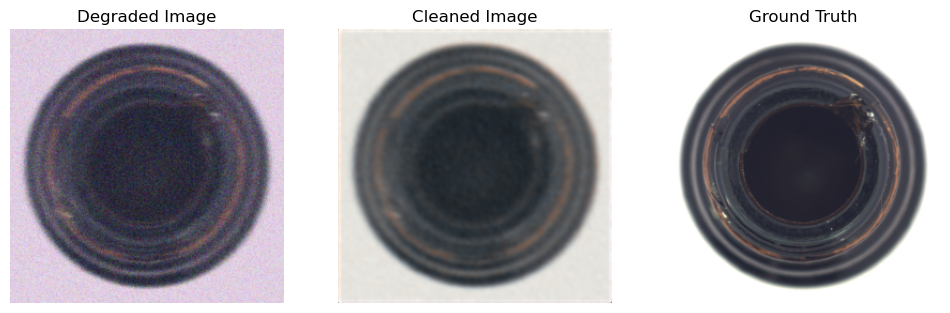

cable
For the Object
Average PSNR: 22.82332952776283, Average SSIM: 0.8224625587463379
For the sample image
PSNR: 23.006872921837065, SSIM: 0.6409076452255249


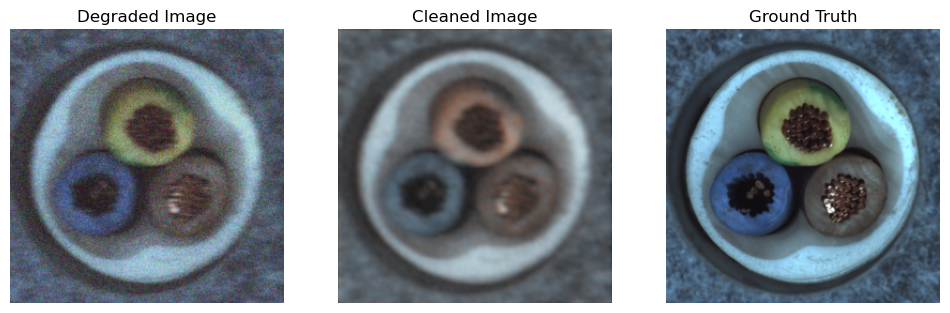

capsule
For the Object
Average PSNR: 28.57085419990307, Average SSIM: 0.7354116439819336
For the sample image
PSNR: 28.808288223513756, SSIM: 0.883667528629303


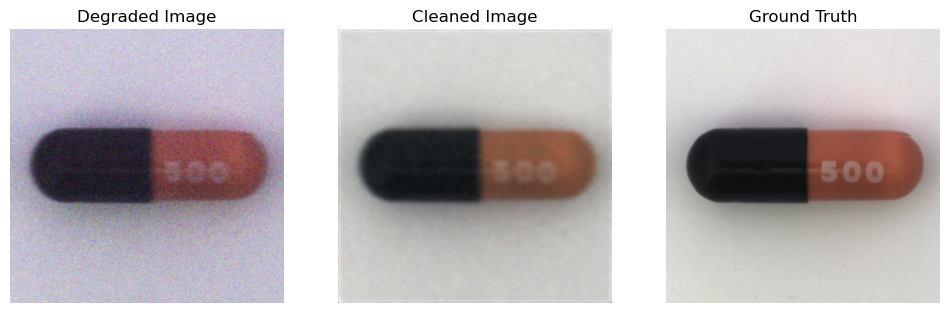

carpet
For the Object
Average PSNR: 20.017442772997388, Average SSIM: 0.3526543080806732
For the sample image
PSNR: 20.042816077268316, SSIM: 0.38979554176330566


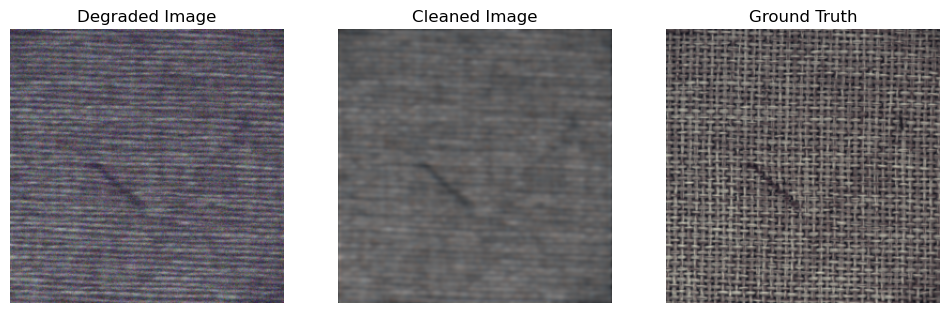

grid
For the Object
Average PSNR: 22.521293484017754, Average SSIM: 0.6861646175384521
For the sample image
PSNR: 22.344074631264963, SSIM: 0.4566068947315216


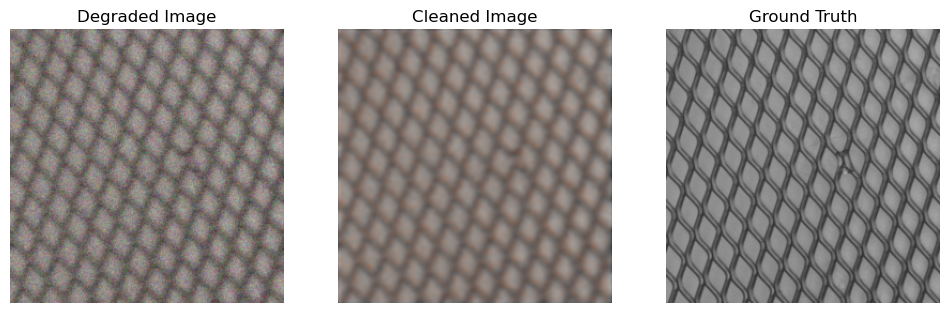

hazelnut
For the Object
Average PSNR: 28.85576372165137, Average SSIM: 0.8914971351623535
For the sample image
PSNR: 27.382879045619198, SSIM: 0.9179485440254211


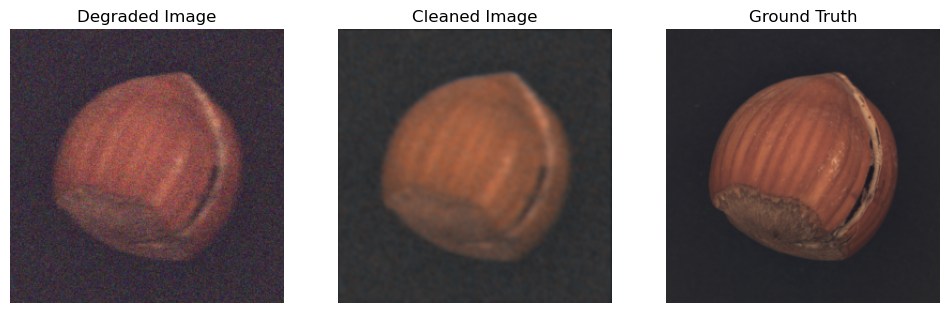

leather
For the Object
Average PSNR: 28.113095201951236, Average SSIM: 0.934370756149292
For the sample image
PSNR: 26.317203634457456, SSIM: 0.9217358827590942


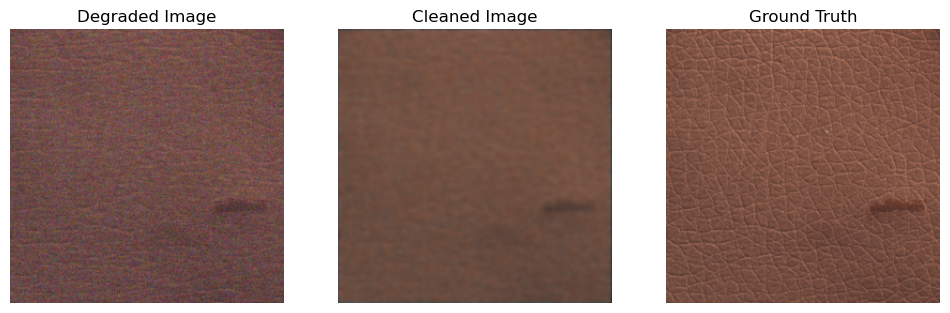

metal_nut
For the Object
Average PSNR: 26.027943986033986, Average SSIM: 0.7652402520179749
For the sample image
PSNR: 25.772031686436403, SSIM: 0.694105863571167


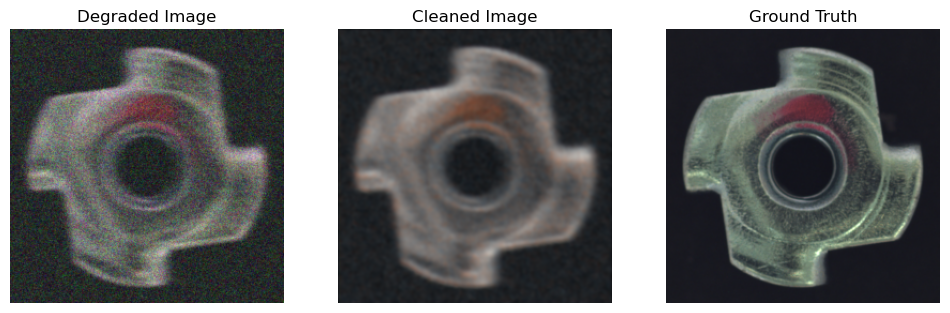

pill
For the Object
Average PSNR: 26.926203596495792, Average SSIM: 0.6906461715698242
For the sample image
PSNR: 26.245062278458413, SSIM: 0.5485196709632874


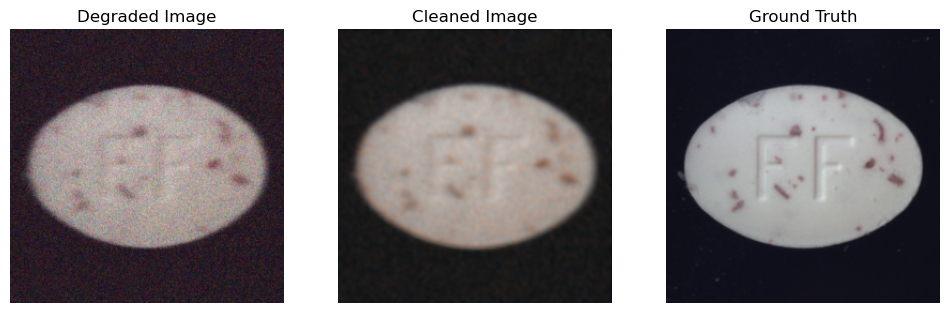

screw
For the Object
Average PSNR: 26.44299332782484, Average SSIM: 0.6988197565078735
For the sample image
PSNR: 28.5680894965707, SSIM: 0.5898870229721069


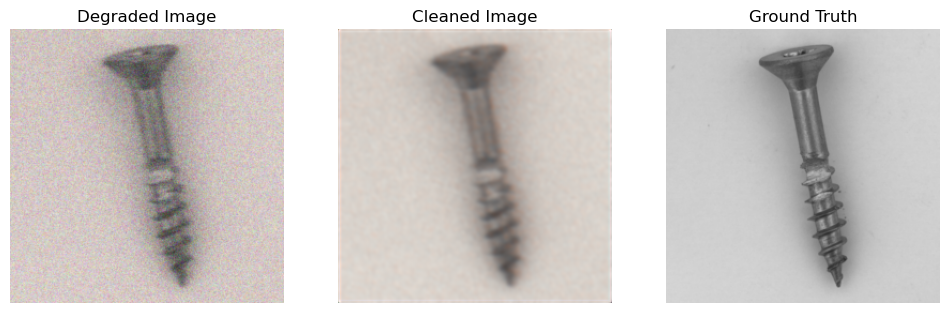

tile
For the Object
Average PSNR: 23.208538009915564, Average SSIM: 0.6675227880477905
For the sample image
PSNR: 23.13823121029074, SSIM: 0.6338900327682495


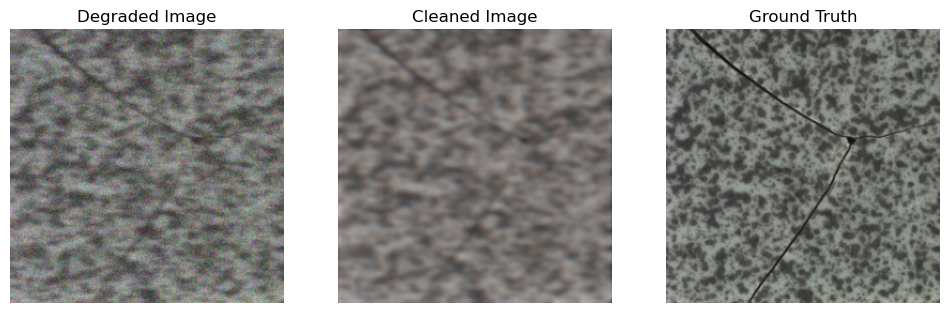

toothbrush
For the Object
Average PSNR: 26.2288607480037, Average SSIM: 0.7313435077667236
For the sample image
PSNR: 24.820418734435986, SSIM: 0.8053616285324097


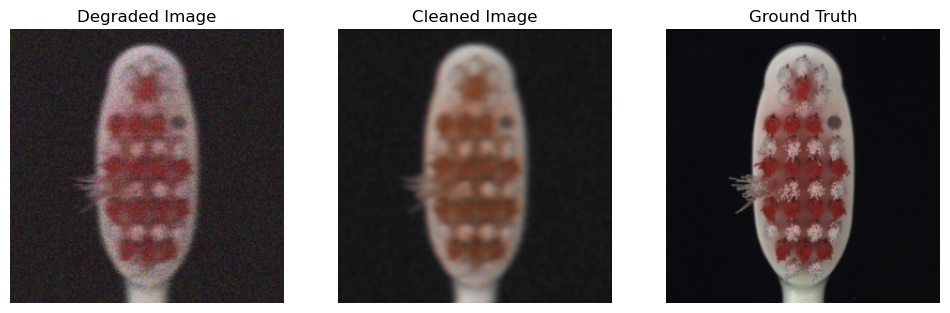

transistor
For the Object
Average PSNR: 25.429722739098132, Average SSIM: 0.9054614305496216
For the sample image
PSNR: 25.320749086374303, SSIM: 0.92680823802948


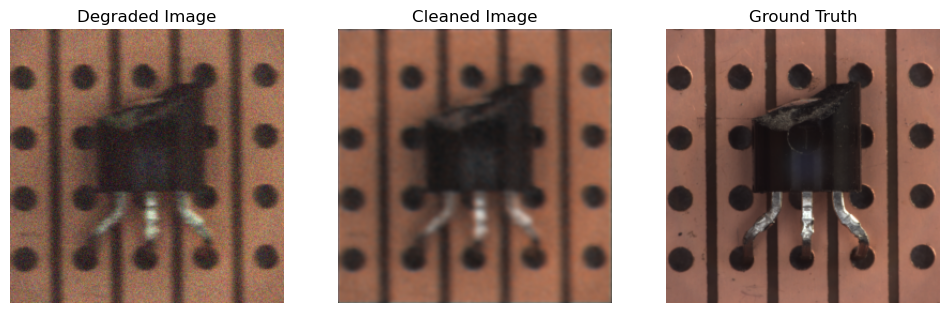

wood
For the Object
Average PSNR: 24.896867646377366, Average SSIM: 0.9439267516136169
For the sample image
PSNR: 24.470408205974156, SSIM: 0.9756253957748413


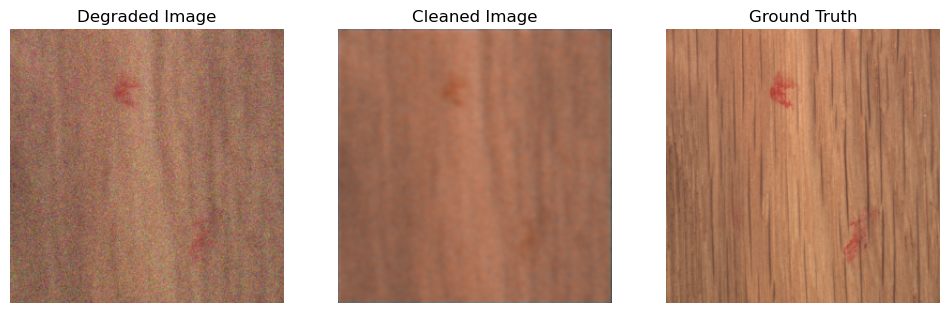

zipper
For the Object
Average PSNR: 22.686420058431928, Average SSIM: 0.5962131023406982
For the sample image
PSNR: 22.26095161327993, SSIM: 0.6481047868728638


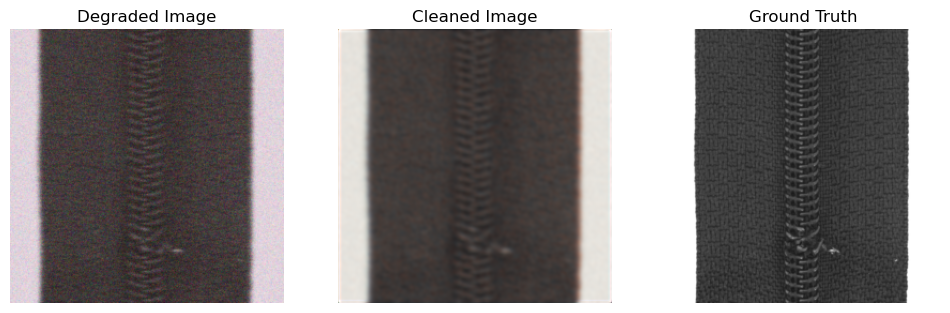

In [190]:
model.eval()
num_samples = 10
psnr_ssim_obj = {}

for obj in object_folders:
    print(obj)
    print('For the Object')
    psnr,ssim = evaluate_model(model,val_loaders_by_obj[obj])
    psnr_ssim_obj[obj] = {'psnr':psnr[0],'ssim':ssim[0]}

    degraded,ground_truth,_  =  val_datasets_by_obj[obj][0]

    X = degraded.unsqueeze(0)
    output = model(X).squeeze(0)

    print('For the sample image')
    evaluate_single_image(model,degraded,ground_truth)

    degraded = degraded.clamp(0,1)
    output = output.clamp(0,1)

    _,ax = plt.subplots(1,3,figsize=(12,6))
    ax[0].imshow(degraded.permute(1,2,0).cpu().detach().numpy())
    ax[0].set_title('Degraded Image')
    ax[0].axis('off')

    ax[1].imshow(output.permute(1,2,0).cpu().detach().numpy())
    ax[1].set_title('Cleaned Image')
    ax[1].axis('off')

    ax[2].imshow(ground_truth.permute(1,2,0).cpu().detach().numpy())
    ax[2].set_title('Ground Truth')
    ax[2].axis('off')

    plt.show()


        


In [193]:
psnr_ssim_obj

{'bottle': {'psnr': 21.68371310956692, 'ssim': 0.6102213},
 'cable': {'psnr': 22.82332952776283, 'ssim': 0.82246256},
 'capsule': {'psnr': 28.57085419990307, 'ssim': 0.73541164},
 'carpet': {'psnr': 20.017442772997388, 'ssim': 0.3526543},
 'grid': {'psnr': 22.521293484017754, 'ssim': 0.6861646},
 'hazelnut': {'psnr': 28.85576372165137, 'ssim': 0.89149714},
 'leather': {'psnr': 28.113095201951236, 'ssim': 0.93437076},
 'metal_nut': {'psnr': 26.027943986033986, 'ssim': 0.76524025},
 'pill': {'psnr': 26.926203596495792, 'ssim': 0.6906462},
 'screw': {'psnr': 26.44299332782484, 'ssim': 0.69881976},
 'tile': {'psnr': 23.208538009915564, 'ssim': 0.6675228},
 'toothbrush': {'psnr': 26.2288607480037, 'ssim': 0.7313435},
 'transistor': {'psnr': 25.429722739098132, 'ssim': 0.90546143},
 'wood': {'psnr': 24.896867646377366, 'ssim': 0.94392675},
 'zipper': {'psnr': 22.686420058431928, 'ssim': 0.5962131}}

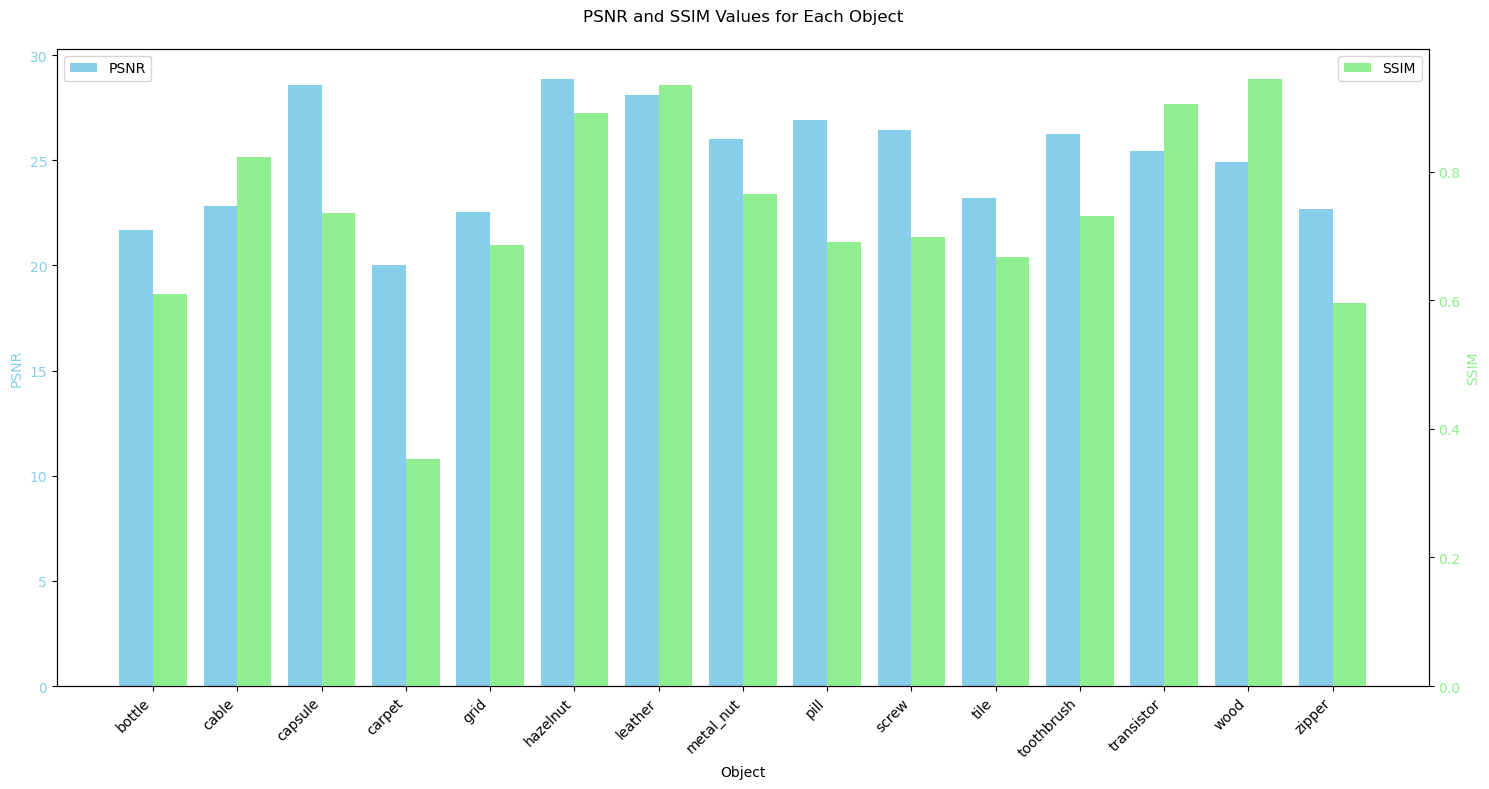

In [194]:
# Extract object names, PSNR and SSIM values
object_names = list(psnr_ssim_obj.keys())
psnr_values = [psnr_ssim_obj[obj]['psnr'] for obj in object_names]
ssim_values = [psnr_ssim_obj[obj]['ssim'] for obj in object_names]

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(15, 8))

# Define x positions for bars
x = np.arange(len(object_names))

# Plot PSNR bars on the left y-axis
bars1 = ax1.bar(x - 0.2, psnr_values, width=0.4, color='skyblue', label='PSNR')
ax1.set_xlabel('Object')
ax1.set_ylabel('PSNR', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# Create second y-axis for SSIM values
ax2 = ax1.twinx()
bars2 = ax2.bar(x + 0.2, ssim_values, width=0.4, color='lightgreen', label='SSIM')
ax2.set_ylabel('SSIM', color='lightgreen')
ax2.tick_params(axis='y', labelcolor='lightgreen')

# Set x-axis labels
ax1.set_xticks(x)
ax1.set_xticklabels(object_names, rotation=45, ha='right')

# Add legends
ax1.legend(bars1, ['PSNR'], loc='upper left')
ax2.legend(bars2, ['SSIM'], loc='upper right')

# Title
plt.title('PSNR and SSIM Values for Each Object', pad=20)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()